# system for running multiple players at once

## imports


In [1]:
import os
import mido
import random
import pretty_midi
from mido import MidiFile, Message
import threading
from threading import Thread, Event
from queue import Queue
import simpleaudio as sa
from pathlib import Path
from datetime import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import wave

## player class


In [2]:
class SimplePlayer:
    do_tick = True

    def __init__(
        self,
        name: str,
        sound: str,
        kill_event: Event,
        playback_event: Event,
        play_event: Event,
        filename_queue: Queue,
    ) -> None:
        self.name = name
        self.sound = sound
        self.play = play_event
        self.kill_event = kill_event
        self.get_next = playback_event
        self.file_queue = filename_queue

    def playback_loop(self):
        self.get_next.set()

        while not self.kill_event.is_set():
            # get next file from queue
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} waiting for file"
            )
            self.playing_file_path = self.file_queue.get()
            self.playing_file = os.path.basename(self.playing_file_path)
            self.get_next.set()

            # print progress
            file_tempo = int(os.path.basename(self.playing_file).split("-")[1])
            found_tempo = -1
            for track in MidiFile(self.playing_file_path).tracks:
                for msg in track:
                    if msg.type == "set_tempo":
                        found_tempo = msg.tempo
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} playing '{self.playing_file}' ({file_tempo}BPM --> {round(mido.tempo2bpm(found_tempo)):01d}BPM)"
            )

            # play file
            self.play_midi_file(self.playing_file_path)

        print(f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} shutting down")

    def play_midi_file(self, midi_path: str) -> None:
        midi = MidiFile(midi_path)

        with mido.open_output("Disklavier") as outport:  # type: ignore
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} waiting to play"
            )
            while not self.play.is_set():
                time.sleep(0.0000001)

            self.play.clear()
            print(f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} playing")

            last_beat = time.time()
            for msg in midi.play(meta_messages=True):
                if not msg.is_meta:
                    outport.send(msg)
                else:
                    if msg.type == "set_tempo":  # type: ignore
                        print(f"\t\tplaying at {mido.tempo2bpm(msg.tempo)} BPM", msg)  # type: ignore
                    if msg.type == "text":  # type: ignore
                        beat = time.time()
                        print(
                            f"[{datetime.now().strftime('%H:%M:%S.%f')}] {self.name} {msg.text} ({beat - last_beat:.05f}s)"
                        )
                        last_beat = beat
                        sa.WaveObject.from_wave_file(self.sound).play()

                # end active notes and return if killed
                if self.kill_event.is_set():
                    with mido.open_output("Disklavier") as outport:  # type: ignore
                        for note in range(128):
                            msg = Message("note_off", note=note, velocity=0, channel=0)
                            outport.send(msg)
                    break

## helper functions


In [3]:
def change_tempo(midi_file_path: str, new_bpm: int = 80) -> str:
    midi = mido.MidiFile(midi_file_path)
    new_tempo = mido.bpm2tempo(new_bpm)
    new_message = mido.MetaMessage("set_tempo", tempo=new_tempo, time=0)
    tempo_added = False

    for track in midi.tracks:
        for msg in track:
            if msg.type == "set_tempo":
                track.remove(msg)
                # print(f"removed set tempo message", msg)

        if not tempo_added:
            track.insert(0, new_message)
            # print(f"adding message (tempo={new_bpm}) {new_message}")
            tempo_added = True

    # if no tracks had a set_tempo message and no new one was added, add a new track with the tempo message
    if not tempo_added:
        new_track = mido.MidiTrack()
        print(f"adding message to new track {new_message}")
        new_track.append(new_message)
        midi.tracks.append(new_track)

    new_file_path = os.path.join("tmp/playlist", f"{Path(midi_file_path).stem}.mid")
    midi.save(new_file_path)

    return new_file_path

In [4]:
def draw_piano_roll(piano_roll, beats=[0], fs=100, title="Piano Roll") -> None:
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 8))
    plt.imshow(
        piano_roll, aspect="auto", origin="lower", cmap="magma", interpolation="nearest"
    )
    plt.vlines([b * fs for b in beats], 0, 120, "g", linewidth=1, alpha=0.4)
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("MIDI Note Number")
    plt.colorbar()

    tick_spacing = 1
    ticks = np.arange(0, len(piano_roll.T) / fs, tick_spacing)
    plt.xticks(ticks * fs, labels=[f"{int(tick)}" for tick in ticks])
    plt.show()

In [5]:
def calc_beats(tempo: int, start_time_seconds: float, end_time_seconds: float):
    beat_duration = 60 / tempo
    current_time = start_time_seconds
    beat_times = []

    while current_time <= end_time_seconds:
        beat_times.append(current_time)
        current_time += beat_duration

    return beat_times

In [6]:
def metronome(
    tempo: int, ready_event: Event, go_event: Event, kill_event: Event, bps: int = 8
):
    tick_rate = 60.0 / tempo

    tick = sa.WaveObject.from_wave_file("../data/m_kick.wav")
    tick_len = 0
    with wave.open("../data/m_kick.wav", "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        tick_len = frames / float(rate)

    print(
        f"ticking every {tick_rate:.01f} seconds ({tick_len:.05f} -> {tick_rate - tick_len:.05f})"
    )

    beats = 0
    last_beat = time.time()
    while not kill_event.is_set():
        beat = time.time()

        if beats // bps:
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] beat {beats}    ({beat - last_beat:.05f}s)\tgo!"
            )
            go_event.set()
            beats = 0
        elif beats // (bps - 1):
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] beat {beats}    ({beat - last_beat:.05f}s)\tready?"
            )
            ready_event.set()
        else:
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] beat {beats}    ({beat - last_beat:.05f}s)"
            )

        tick.play()
        time.sleep(tick_rate - tick_len / 2)

        last_beat = beat
        beats += 1
    print("metronome shutting down")

## build players


### setup players


In [7]:
kill_p1 = Event()
give_p1 = Event()
plst_p1 = Queue()
kill_p2 = Event()
give_p2 = Event()
plst_p2 = Queue()
play_event = Event()

player1 = SimplePlayer(
    "p1", "../data/m_tick.wav", kill_p1, give_p1, play_event, plst_p1
)
thread_p1 = Thread(target=player1.playback_loop, args=(), name="p1")

player2 = SimplePlayer("p2", "../data/m_hat.wav", kill_p2, give_p2, play_event, plst_p2)
thread_p2 = Thread(target=player2.playback_loop, args=(), name="p2")

### setup control metronome


In [8]:
kill_metro = Event()
ready_event = Event()

bpm = 60

thread_metro = Thread(target=metronome, args=(bpm, ready_event, play_event, kill_metro))

### play


[15:29:59.881072] p1 waiting for file[15:29:59.881393] p2 waiting for file

ticking every 1.0 seconds (0.05510 -> 0.94490)
[15:29:59.915918] beat 0    (0.00000s)
[15:30:01.019205] beat 1    (1.10328s)
[15:30:02.040811] beat 2    (1.02161s)
[15:30:03.044625] beat 3    (1.00381s)
[15:30:04.042975] beat 4    (0.99835s)
[15:30:05.041553] beat 5    (0.99858s)
[15:30:06.058527] beat 6    (1.01697s)
[15:30:07.067935] beat 7    (1.00940s)	ready?
[15:30:07.090518] putting next file in p1's queue: tmp/playlist/20240121-70-03_0112-0120.mid True
[15:30:07.091903] p1 playing '20240121-70-03_0112-0120.mid' (70BPM --> 60BPM)
[15:30:07.110591] p1 waiting to play


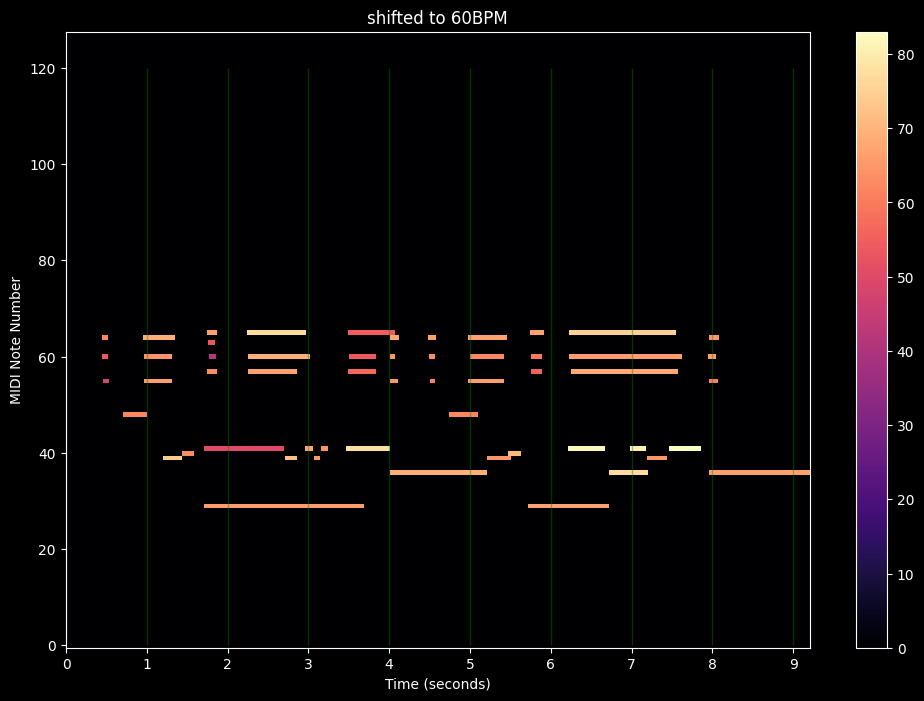

[15:30:08.068773] beat 8    (1.00084s)	go!
[15:30:08.098775] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:08.099239] p1 beat 0 (0.00044s)
[15:30:09.082999] beat 1    (1.01423s)
[15:30:09.125859] p1 beat 1 (1.02662s)
[15:30:10.109161] p1 beat 2 (0.98330s)[15:30:10.109268] beat 2    (1.02627s)

[15:30:11.110083] p1 beat 3 (1.00092s)
[15:30:11.129007] beat 3    (1.01974s)
[15:30:12.110158] p1 beat 4 (1.00007s)
[15:30:12.129131] beat 4    (1.00012s)
[15:30:13.105634] p1 beat 5 (0.99548s)
[15:30:13.118438] beat 5    (0.98931s)
[15:30:14.110091] p1 beat 6 (1.00446s)
[15:30:14.122972] beat 6    (1.00453s)
[15:30:15.107503] p1 beat 7 (0.99741s)[15:30:15.113954] beat 7    (0.99098s)	ready?

[15:30:15.134480] putting next file in p2's queue: tmp/playlist/20240123-70-04_0976-0984.mid True
[15:30:15.135317] p2 playing '20240123-70-04_0976-0984.mid' (70BPM --> 60BPM)
[15:30:15.135986] p2 waiting to play


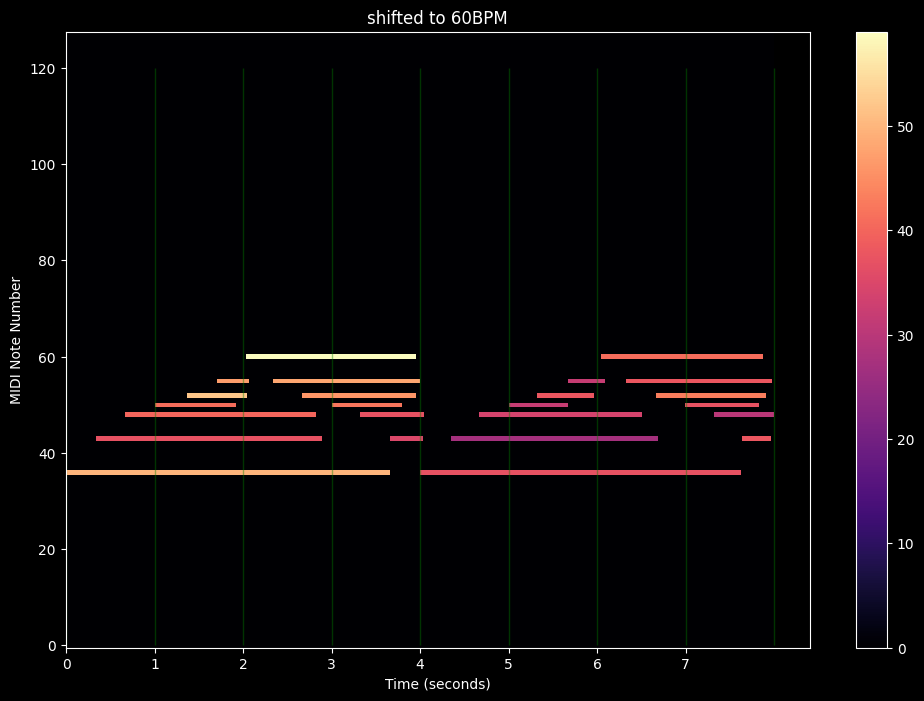

[15:30:16.102712] beat 8    (0.98876s)	go!
[15:30:16.120420] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:16.120712] p2 beat 0 (0.00027s)
[15:30:16.127029] p1 beat 8 (1.01953s)
[15:30:17.110775] beat 1    (1.00806s)[15:30:17.129699] p2 beat 1 (1.00899s)

[15:30:17.324633] p1 waiting for file
[15:30:18.128248] p2 beat 2 (0.99855s)[15:30:18.134518] beat 2    (1.02375s)

[15:30:19.131731] p2 beat 3 (1.00348s)[15:30:19.144354] beat 3    (1.00984s)

[15:30:20.131750] p2 beat 4 (1.00002s)
[15:30:20.144640] beat 4    (1.00029s)
[15:30:21.131789] p2 beat 5 (1.00004s)
[15:30:21.144688] beat 5    (1.00005s)
[15:30:22.131731] p2 beat 6 (0.99994s)[15:30:22.131806] beat 6    (0.98712s)

[15:30:23.122684] p2 beat 7 (0.99095s)
[15:30:23.147669] beat 7    (1.01586s)	ready?
[15:30:23.170707] putting next file in p1's queue: tmp/playlist/20231220-80-03_0304-0312.mid True
[15:30:23.171514] p1 playing '20231220-80-03_0304-0312.mid' (80BPM --> 60BPM)
[15:30:23.175

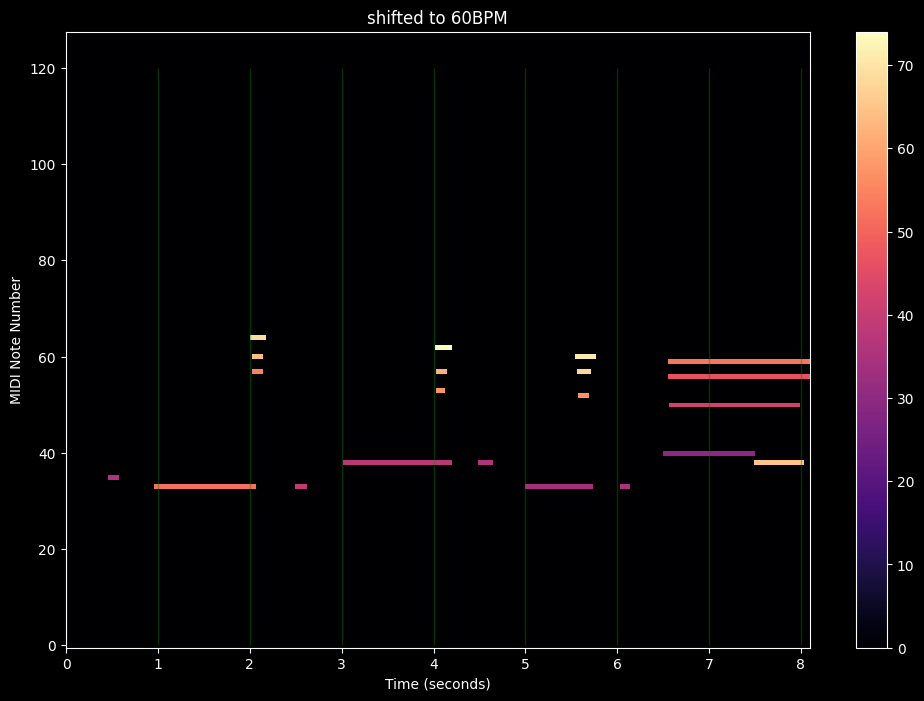

[15:30:24.126266] p2 beat 8 (1.00358s)[15:30:24.132630] beat 8    (0.98496s)	go!

[15:30:24.143012] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:24.143259] p1 beat 0 (0.00023s)
[15:30:25.122588] beat 1    (0.98995s)[15:30:25.129135] p2 waiting for file

[15:30:25.154314] p1 beat 1 (1.01105s)
[15:30:26.124962] beat 2    (1.00238s)
[15:30:26.154344] p1 beat 2 (1.00003s)
[15:30:27.123497] beat 3    (0.99854s)
[15:30:27.149867] p1 beat 3 (0.99552s)
[15:30:28.138536] beat 4    (1.01504s)[15:30:28.144909] p1 beat 4 (0.99504s)

[15:30:29.143681] beat 5    (1.00514s)[15:30:29.150061] p1 beat 5 (1.00515s)

[15:30:30.142252] beat 6    (0.99857s)[15:30:30.148508] p1 beat 6 (0.99845s)

[15:30:31.140495] beat 7    (0.99824s)	ready?
[15:30:31.155145] p1 beat 7 (1.00664s)
[15:30:31.167751] putting next file in p2's queue: tmp/playlist/20240117-64-04_0376-0384.mid True
[15:30:31.168768] p2 playing '20240117-64-04_0376-0384.mid' (64BPM --> 60BPM)
[15:30:31.173

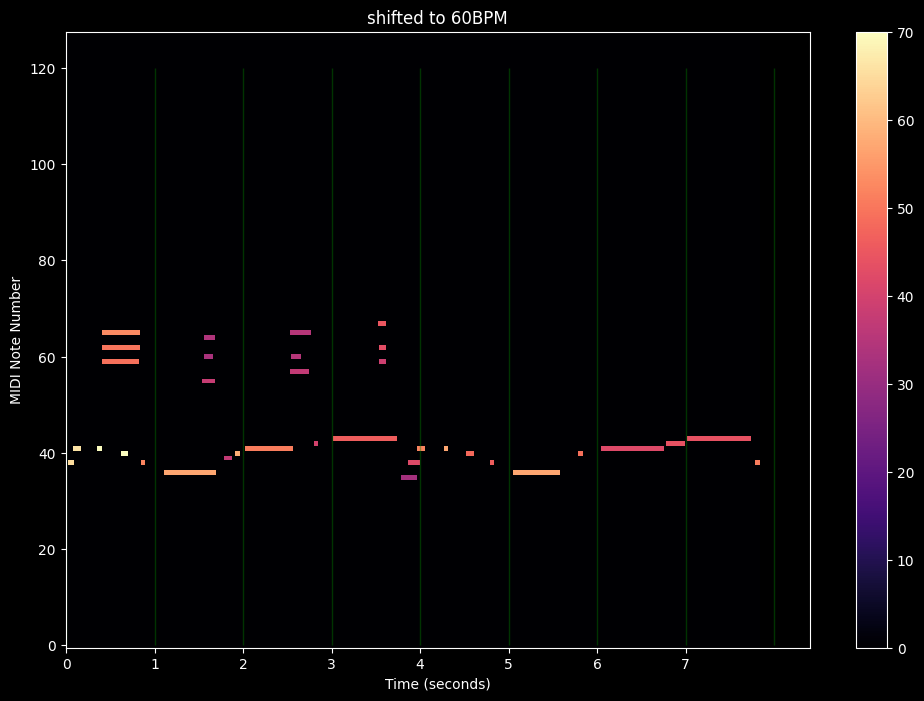

[15:30:32.135213] beat 8    (0.99472s)	go!
[15:30:32.153789] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:32.154119] p2 beat 0 (0.00031s)
[15:30:32.160442] p1 beat 8 (1.00530s)
[15:30:33.137866] beat 1    (1.00265s)
[15:30:33.158697] p1 waiting for file
[15:30:33.171016] p2 beat 1 (1.01690s)
[15:30:34.142380] beat 2    (1.00451s)
[15:30:34.173798] p2 beat 2 (1.00278s)
[15:30:35.159730] p2 beat 3 (0.98593s)[15:30:35.159807] beat 3    (1.01743s)

[15:30:36.162181] p2 beat 4 (1.00245s)[15:30:36.162266] beat 4    (1.00246s)

[15:30:37.160897] p2 beat 5 (0.99872s)[15:30:37.160980] beat 5    (0.99871s)

[15:30:38.148532] beat 6    (0.98755s)
[15:30:38.173996] p2 beat 6 (1.01310s)
[15:30:39.155995] beat 7    (1.00746s)	ready?[15:30:39.156109] p2 beat 7 (0.98211s)

[15:30:39.190108] putting next file in p1's queue: tmp/playlist/20240213-100-05_0088-0096.mid True
[15:30:39.191053] p1 playing '20240213-100-05_0088-0096.mid' (100BPM --> 60BPM)
[15:30:39.

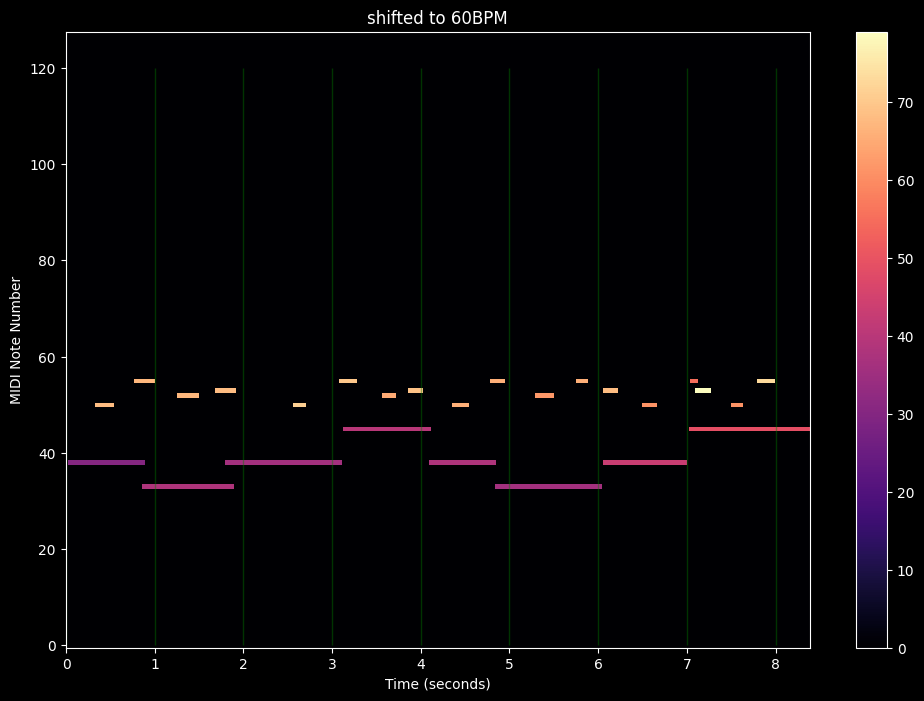

[15:30:40.153798] beat 8    (0.99780s)	go!
[15:30:40.176267] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:40.176615] p1 beat 0 (0.00031s)
[15:30:40.176650] p2 beat 8 (1.02054s)
[15:30:41.159402] beat 1    (1.00561s)
[15:30:41.184730] p2 waiting for file
[15:30:41.184794] p1 beat 1 (1.00818s)
[15:30:42.158252] beat 2    (0.99885s)
[15:30:42.191906] p1 beat 2 (1.00711s)
[15:30:43.173513] beat 3    (1.01526s)[15:30:43.179894] p1 beat 3 (0.98799s)

[15:30:44.187588] p1 beat 4 (1.00769s)[15:30:44.194005] beat 4    (1.02049s)

[15:30:45.187810] p1 beat 5 (1.00022s)
[15:30:45.194275] beat 5    (1.00027s)
[15:30:46.187573] beat 6    (0.99330s)[15:30:46.187641] p1 beat 6 (0.99983s)

[15:30:47.181924] p1 beat 7 (0.99428s)[15:30:47.182004] beat 7    (0.99443s)	ready?

[15:30:47.212548] putting next file in p2's queue: tmp/playlist/20231227-80-01_0048-0056.mid True
[15:30:47.213392] p2 playing '20231227-80-01_0048-0056.mid' (80BPM --> 60BPM)
[15:30:47.217

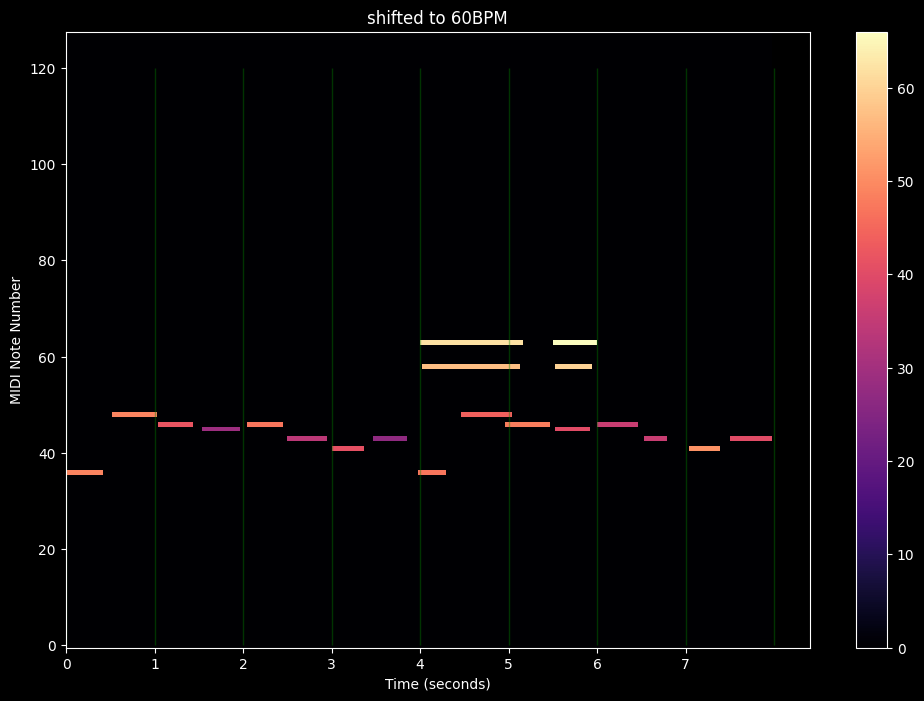

[15:30:48.188763] beat 8    (1.00676s)	go!
[15:30:48.226482] p1 beat 8 (1.04456s)
[15:30:48.226523] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:48.226789] p2 beat 0 (0.00024s)
[15:30:49.185392] p1 waiting for file
[15:30:49.203927] beat 1    (1.01517s)
[15:30:49.237820] p2 beat 1 (1.01103s)
[15:30:50.206009] beat 2    (1.00208s)
[15:30:50.236762] p2 beat 2 (0.99894s)
[15:30:51.216742] beat 3    (1.01073s)
[15:30:51.252841] p2 beat 3 (1.01608s)
[15:30:52.235692] p2 beat 4 (0.98285s)[15:30:52.235769] beat 4    (1.01903s)

[15:30:53.237849] p2 beat 5 (1.00216s)
[15:30:53.253084] beat 5    (1.01731s)
[15:30:54.228761] p2 beat 6 (0.99091s)
[15:30:54.246627] beat 6    (0.99354s)
[15:30:55.237823] p2 beat 7 (1.00906s)[15:30:55.244198] beat 7    (0.99757s)	ready?

[15:30:55.270162] putting next file in p1's queue: tmp/playlist/20240117-64-06_0392-0400.mid True
[15:30:55.271774] p1 playing '20240117-64-06_0392-0400.mid' (64BPM --> 60BPM)
[15:30:55.276

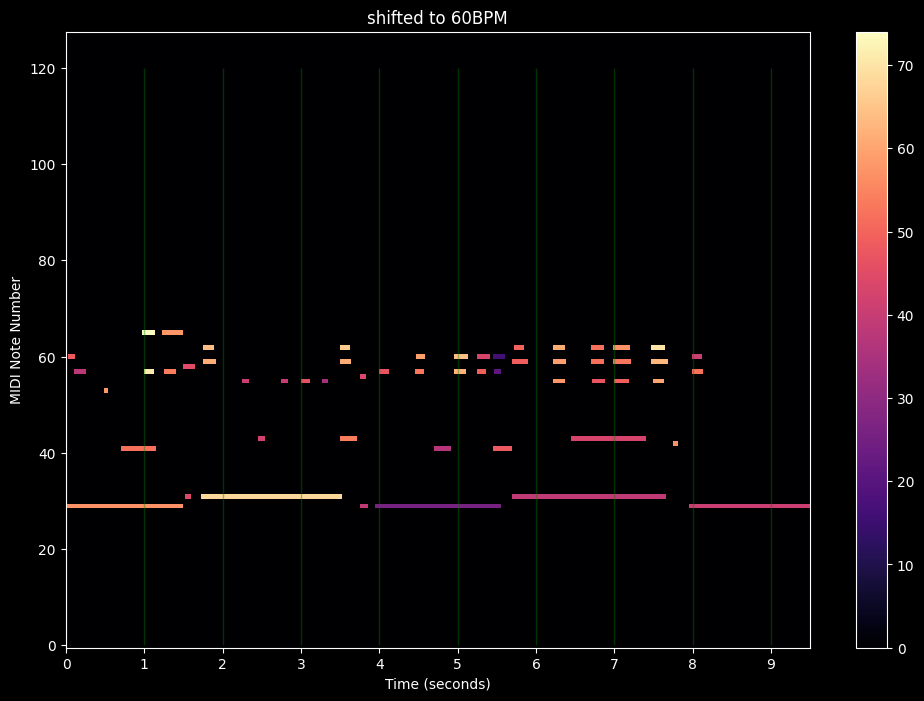

[15:30:56.233513] p2 beat 8 (0.99569s)[15:30:56.233614] beat 8    (0.98942s)	go!

[15:30:56.269367] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:30:56.269844] p1 beat 0 (0.00046s)
[15:30:57.240773] p2 waiting for file[15:30:57.240862] beat 1    (1.00725s)

[15:30:57.276595] p1 beat 1 (1.00675s)
[15:30:58.249409] beat 2    (1.00855s)
[15:30:58.280665] p1 beat 2 (1.00407s)
[15:30:59.248277] beat 3    (0.99887s)
[15:30:59.286034] p1 beat 3 (1.00537s)
[15:31:00.276148] p1 beat 4 (0.99011s)[15:31:00.276239] beat 4    (1.02796s)

[15:31:01.280663] p1 beat 5 (1.00452s)[15:31:01.287032] beat 5    (1.01079s)

[15:31:02.280667] p1 beat 6 (1.00000s)[15:31:02.287080] beat 6    (1.00005s)

[15:31:03.271611] p1 beat 7 (0.99094s)[15:31:03.277988] beat 7    (0.99091s)	ready?

[15:31:03.303848] putting next file in p2's queue: tmp/playlist/20231220-80-04_0104-0112.mid True
[15:31:03.304373] p2 playing '20231220-80-04_0104-0112.mid' (80BPM --> 60BPM)
[15:31:03.305

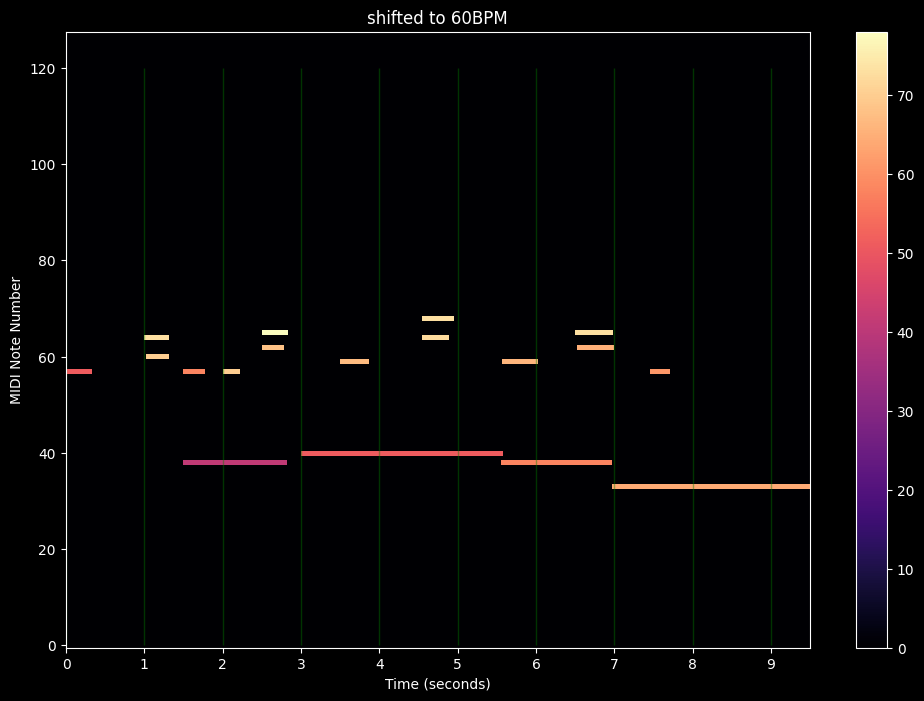

[15:31:04.271047] beat 8    (0.99306s)	go!
[15:31:04.289995] p1 beat 8 (1.01838s)
[15:31:04.290039] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:04.290287] p2 beat 0 (0.00023s)
[15:31:05.274172] beat 1    (1.00312s)
[15:31:05.307290] p2 beat 1 (1.01700s)
[15:31:05.780841] p1 waiting for file
[15:31:06.278546] beat 2    (1.00438s)
[15:31:06.298728] p2 beat 2 (0.99144s)
[15:31:07.277840] beat 3    (0.99929s)
[15:31:07.297066] p2 beat 3 (0.99834s)
[15:31:08.280359] beat 4    (1.00252s)[15:31:08.299200] p2 beat 4 (1.00213s)

[15:31:09.301333] beat 5    (1.02097s)[15:31:09.301425] p2 beat 5 (1.00223s)

[15:31:10.301254] p2 beat 6 (0.99983s)
[15:31:10.319716] beat 6    (1.01839s)
[15:31:11.296845] p2 beat 7 (0.99559s)
[15:31:11.322030] beat 7    (1.00232s)	ready?
[15:31:11.349838] putting next file in p1's queue: tmp/playlist/20240126-50-02_0208-0216.mid True
[15:31:11.351348] p1 playing '20240126-50-02_0208-0216.mid' (50BPM --> 60BPM)
[15:31:11.355

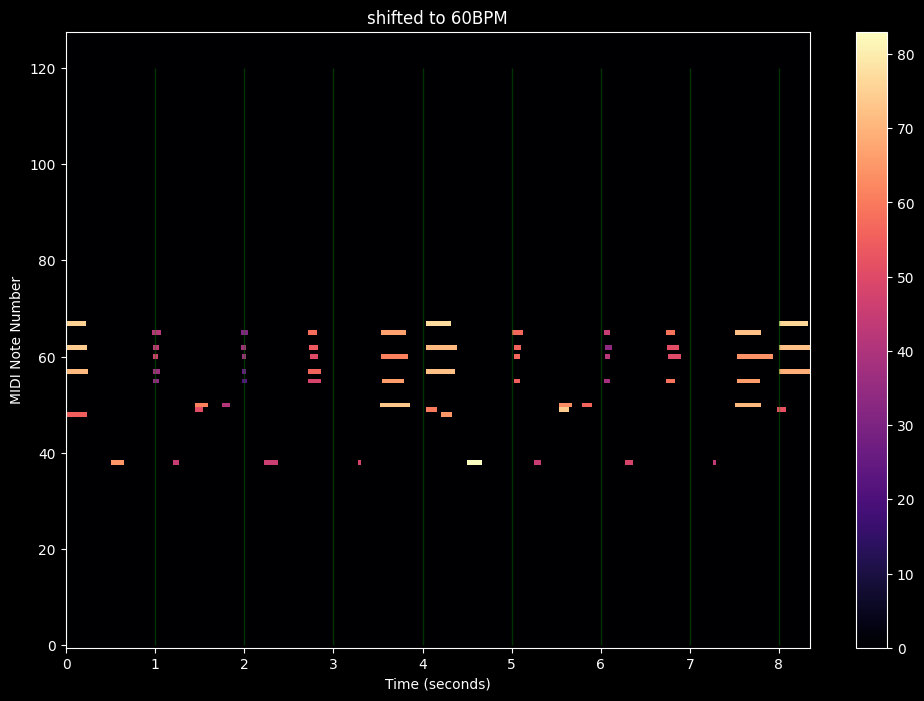

[15:31:12.300886] p2 beat 8 (1.00404s)
[15:31:12.326121] beat 8    (1.00409s)	go!
[15:31:12.341889] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:12.342319] p1 beat 0 (0.00041s)
[15:31:13.332356] beat 1    (1.00624s)
[15:31:13.363272] p1 beat 1 (1.02095s)
[15:31:13.801524] p2 waiting for file
[15:31:14.344552] p1 beat 2 (0.98128s)[15:31:14.344624] beat 2    (1.01227s)

[15:31:15.353196] beat 3    (1.00857s)[15:31:15.353265] p1 beat 3 (1.00871s)

[15:31:16.353183] p1 beat 4 (0.99992s)[15:31:16.359548] beat 4    (1.00635s)

[15:31:17.353201] p1 beat 5 (1.00002s)
[15:31:17.378393] beat 5    (1.01884s)
[15:31:18.353184] p1 beat 6 (0.99998s)
[15:31:18.384606] beat 6    (1.00621s)
[15:31:19.353187] p1 beat 7 (1.00000s)
[15:31:19.394556] beat 7    (1.00995s)	ready?
[15:31:19.409202] putting next file in p2's queue: tmp/playlist/20240121-70-06_0032-0040.mid True
[15:31:19.414061] p2 playing '20240121-70-06_0032-0040.mid' (70BPM --> 60BPM)
[15:31:19.415

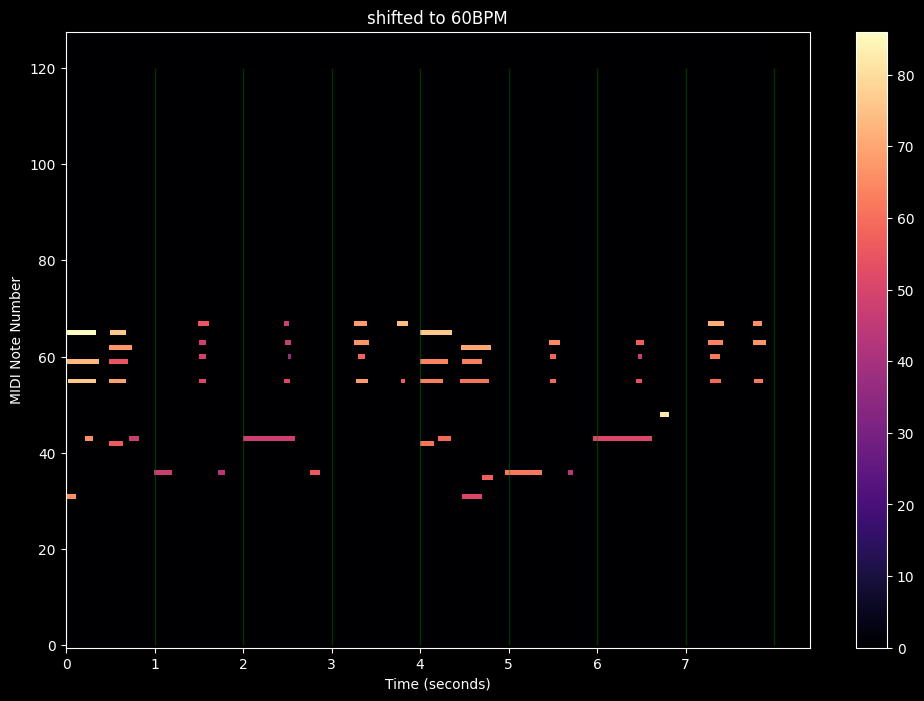

[15:31:20.349288] p1 beat 8 (0.99610s)
[15:31:20.387108] beat 8    (0.99255s)	go!
[15:31:20.404461] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:20.406200] p2 beat 0 (0.00171s)
[15:31:21.357910] p1 waiting for file
[15:31:21.389895] beat 1    (1.00279s)
[15:31:21.411180] p2 beat 1 (1.00498s)
[15:31:22.390273] beat 2    (1.00038s)[15:31:22.409143] p2 beat 2 (0.99796s)

[15:31:23.415774] beat 3    (1.02550s)[15:31:23.415851] p2 beat 3 (1.00671s)

[15:31:24.406729] p2 beat 4 (0.99088s)
[15:31:24.419517] beat 4    (1.00375s)
[15:31:25.413886] beat 5    (0.99437s)[15:31:25.413957] p2 beat 5 (1.00723s)

[15:31:26.415614] beat 6    (1.00173s)[15:31:26.415689] p2 beat 6 (1.00173s)

[15:31:27.415778] p2 beat 7 (1.00009s)
[15:31:27.428593] beat 7    (1.01298s)	ready?
[15:31:27.452426] putting next file in p1's queue: tmp/playlist/20240123-70-04_0592-0600.mid True
[15:31:27.453304] p1 playing '20240123-70-04_0592-0600.mid' (70BPM --> 60BPM)
[15:31:27.453

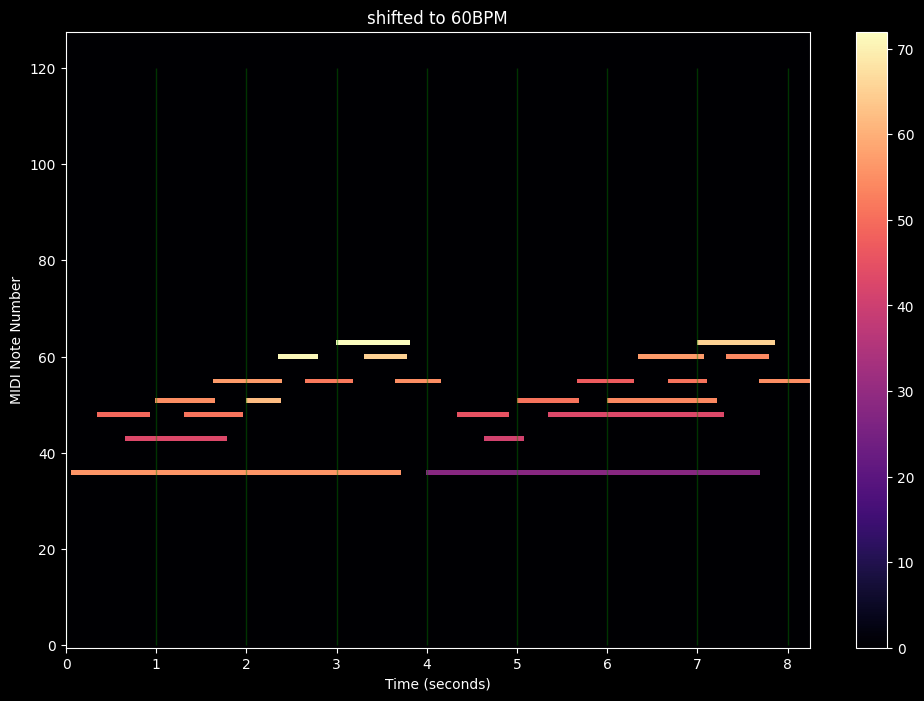

[15:31:28.414059] p2 beat 8 (0.99828s)
[15:31:28.420479] beat 8    (0.99188s)	go!
[15:31:28.451174] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:28.451450] p1 beat 0 (0.00025s)
[15:31:29.420491] p2 waiting for file
[15:31:29.438879] beat 1    (1.01841s)
[15:31:29.455033] p1 beat 1 (1.00358s)
[15:31:30.438798] beat 2    (0.99992s)
[15:31:30.470377] p1 beat 2 (1.01534s)
[15:31:31.453423] p1 beat 3 (0.98305s)
[15:31:31.459818] beat 3    (1.02102s)
[15:31:32.448609] beat 4    (0.98879s)[15:31:32.454980] p1 beat 4 (1.00156s)

[15:31:33.462518] p1 beat 5 (1.00754s)[15:31:33.462582] beat 5    (1.01397s)

[15:31:34.462519] p1 beat 6 (1.00000s)[15:31:34.481500] beat 6    (1.01892s)

[15:31:35.462485] p1 beat 7 (0.99996s)
[15:31:35.481404] beat 7    (0.99990s)	ready?
[15:31:35.509795] putting next file in p2's queue: tmp/playlist/20231227-80-03_0456-0464.mid True
[15:31:35.510097] p2 playing '20231227-80-03_0456-0464.mid' (80BPM --> 60BPM)
[15:31:35.511

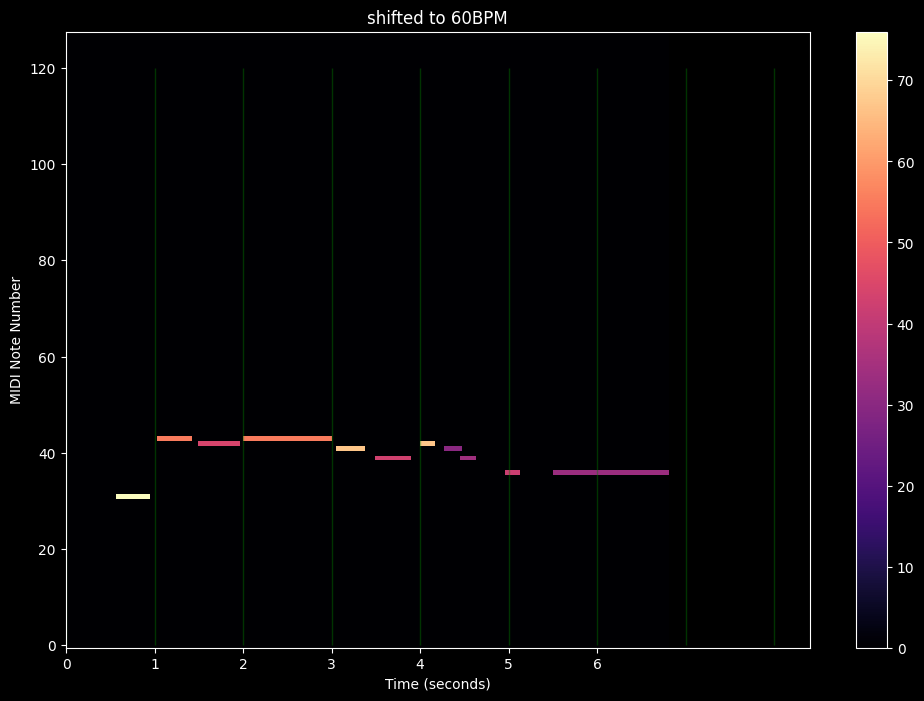

[15:31:36.457651] p1 beat 8 (0.99517s)
[15:31:36.476543] beat 8    (0.99514s)	go!
[15:31:36.502184] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:36.502465] p2 beat 0 (0.00021s)
[15:31:37.467238] p1 waiting for file
[15:31:37.486214] beat 1    (1.00967s)
[15:31:37.513547] p2 beat 1 (1.01108s)
[15:31:38.481842] beat 2    (0.99563s)
[15:31:38.504488] p2 beat 2 (0.99094s)
[15:31:39.488218] beat 3    (1.00637s)
[15:31:39.512070] p2 beat 3 (1.00758s)
[15:31:40.485332] beat 4    (0.99711s)
[15:31:40.510547] p2 beat 4 (0.99848s)
[15:31:41.478501] beat 5    (0.99317s)
[15:31:41.509922] p2 beat 5 (0.99938s)
[15:31:42.480987] beat 6    (1.00249s)
[15:31:42.511424] p2 beat 6 (1.00150s)
[15:31:43.482177] beat 7    (1.00119s)	ready?
[15:31:43.498030] putting next file in p1's queue: tmp/playlist/20240123-70-03_0344-0352.mid True
[15:31:43.499174] p1 playing '20240123-70-03_0344-0352.mid' (70BPM --> 60BPM)
[15:31:43.503261] p1 waiting to play
[15:31:43.50337

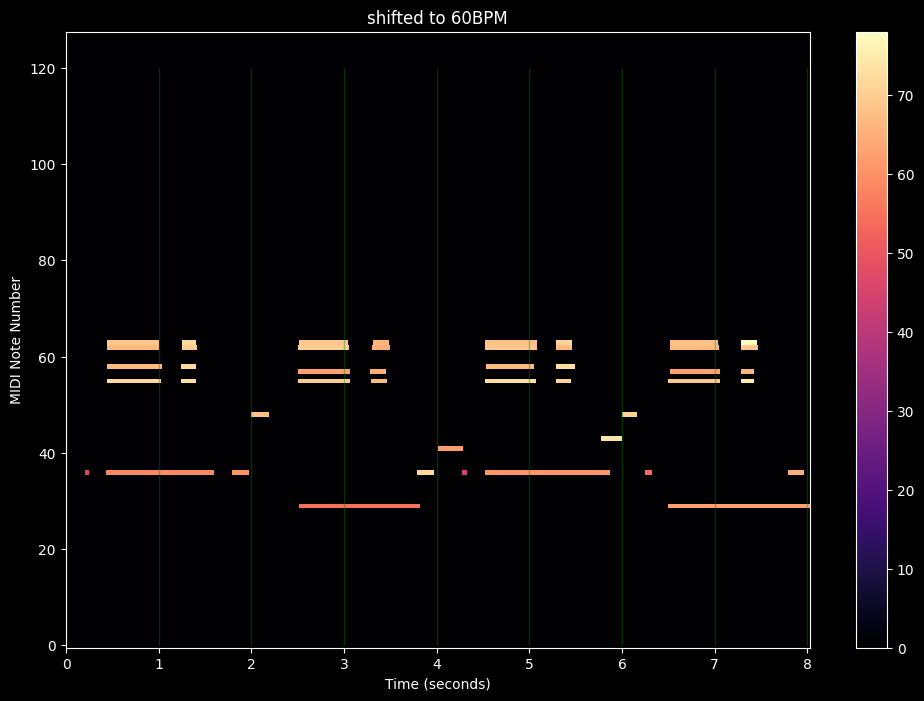

[15:31:44.474911] beat 8    (0.99273s)	go!
[15:31:44.506785] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:44.507177] p1 beat 0 (0.00037s)
[15:31:44.513500] p2 beat 8 (1.01013s)
[15:31:45.497295] beat 1    (1.02238s)[15:31:45.516497] p2 waiting for file
[15:31:45.516528] p1 beat 1 (1.00935s)

[15:31:46.516260] p1 beat 2 (0.99973s)[15:31:46.516332] beat 2    (1.01904s)

[15:31:47.518092] p1 beat 3 (1.00183s)[15:31:47.524474] beat 3    (1.00814s)

[15:31:48.515232] p1 beat 4 (0.99714s)[15:31:48.521620] beat 4    (0.99715s)

[15:31:49.518130] beat 5    (0.99651s)[15:31:49.518259] p1 beat 5 (1.00303s)

[15:31:50.517539] p1 beat 6 (0.99928s)[15:31:50.517609] beat 6    (0.99948s)

[15:31:51.518087] beat 7    (1.00048s)	ready?[15:31:51.518163] p1 beat 7 (1.00062s)

[15:31:51.555018] putting next file in p2's queue: tmp/playlist/20240121-70-06_0056-0064.mid True
[15:31:51.557595] p2 playing '20240121-70-06_0056-0064.mid' (70BPM --> 60BPM)
[15:31:51.560

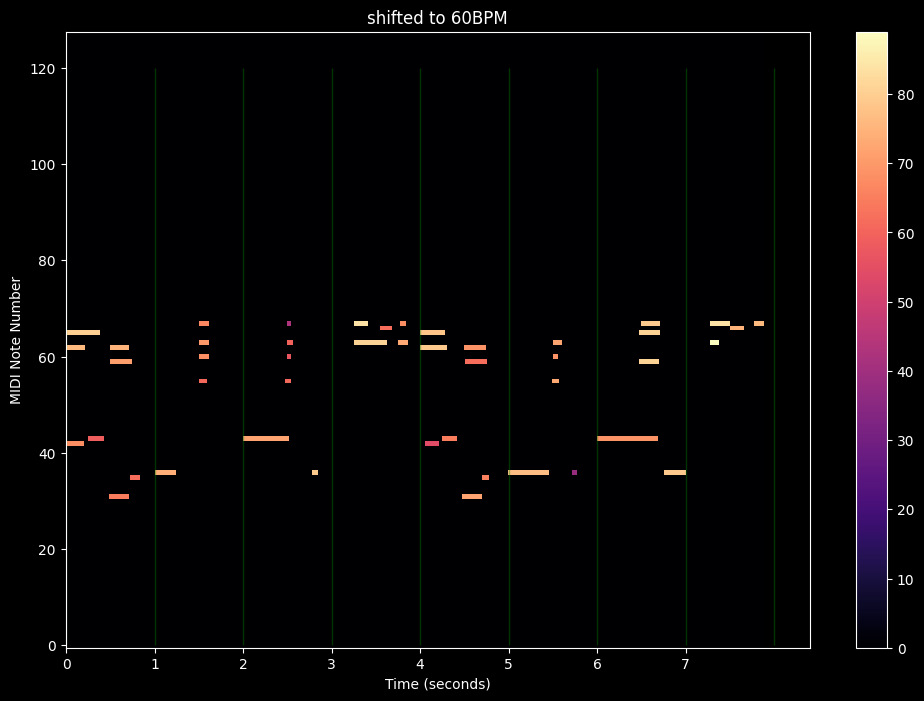

[15:31:52.508382] p1 beat 8 (0.99022s)
[15:31:52.532605] beat 8    (1.01452s)	go!
[15:31:52.552424] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:31:52.552802] p2 beat 0 (0.00035s)
[15:31:53.522744] p1 waiting for file
[15:31:53.541633] beat 1    (1.00903s)
[15:31:53.563767] p2 beat 1 (1.01096s)
[15:31:54.540799] beat 2    (0.99916s)
[15:31:54.579890] p2 beat 2 (1.01612s)
[15:31:55.556941] beat 3    (1.01614s)[15:31:55.563317] p2 beat 3 (0.98343s)

[15:31:56.559319] p2 beat 4 (0.99600s)
[15:31:56.584526] beat 4    (1.02759s)
[15:31:57.554679] p2 beat 5 (0.99536s)[15:31:57.572498] beat 5    (0.98797s)

[15:31:58.558858] p2 beat 6 (1.00418s)
[15:31:58.576765] beat 6    (1.00427s)
[15:31:59.561489] p2 beat 7 (1.00263s)[15:31:59.567855] beat 7    (0.99109s)	ready?

[15:31:59.588926] putting next file in p1's queue: tmp/playlist/20240117-64-2b_0192-0200.mid True
[15:31:59.590037] p1 playing '20240117-64-2b_0192-0200.mid' (64BPM --> 60BPM)
[15:31:59.590

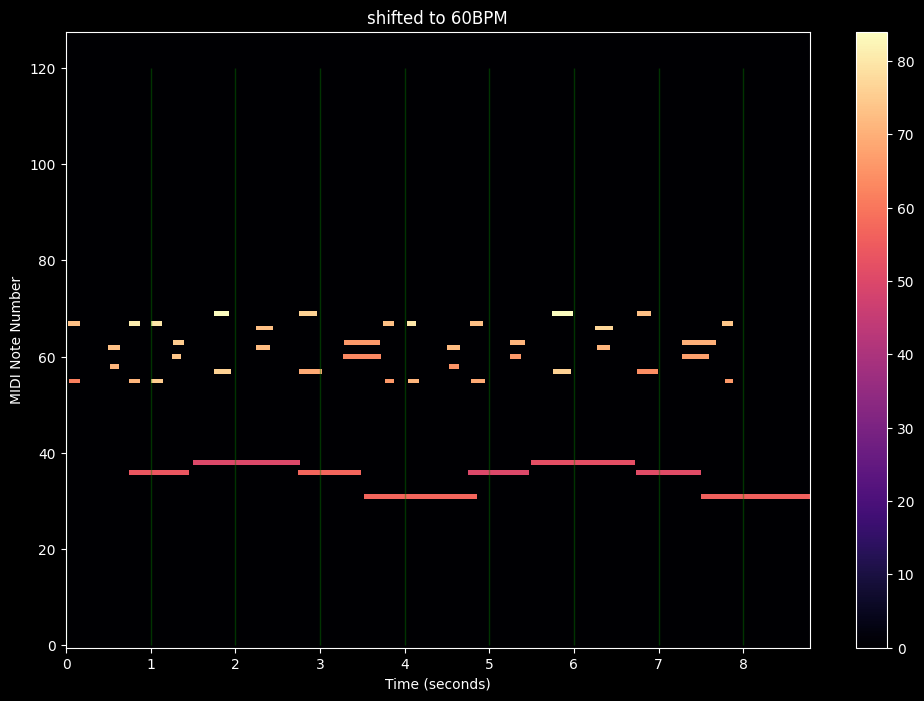

[15:32:00.549000] beat 8    (0.98114s)	go!
[15:32:00.563215] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:00.563568] p1 beat 0 (0.00033s)
[15:32:00.580955] p2 beat 8 (1.01947s)
[15:32:01.559499] beat 1    (1.01050s)[15:32:01.566047] p1 beat 1 (1.00248s)

[15:32:01.591144] p2 waiting for file
[15:32:02.574527] beat 2    (1.01503s)[15:32:02.574623] p1 beat 2 (1.00857s)

[15:32:03.574524] beat 3    (1.00000s)[15:32:03.574607] p1 beat 3 (0.99998s)

[15:32:04.574525] beat 4    (1.00000s)[15:32:04.574597] p1 beat 4 (0.99999s)

[15:32:05.574532] p1 beat 5 (0.99993s)[15:32:05.574634] beat 5    (1.00011s)

[15:32:06.570066] p1 beat 6 (0.99553s)[15:32:06.576553] beat 6    (1.00192s)

[15:32:07.571678] beat 7    (0.99512s)	ready?[15:32:07.571818] p1 beat 7 (1.00175s)

[15:32:07.611448] putting next file in p2's queue: tmp/playlist/20231220-80-08_0328-0336.mid True
[15:32:07.612584] p2 playing '20231220-80-08_0328-0336.mid' (80BPM --> 60BPM)
[15:32:07.616

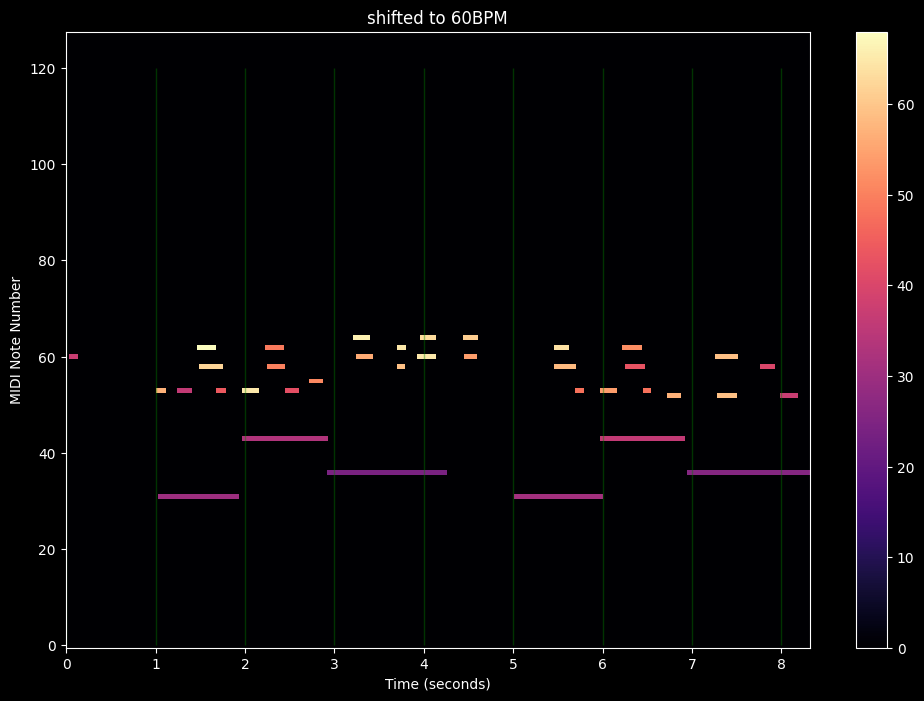

[15:32:08.572352] p1 beat 8 (1.00053s)[15:32:08.572430] beat 8    (1.00075s)	go!
[15:32:08.597409] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:08.597750] p2 beat 0 (0.00031s)

[15:32:09.579069] beat 1    (1.00664s)[15:32:09.579297] p1 waiting for file
[15:32:09.604251] p2 beat 1 (1.00650s)

[15:32:10.606747] p2 beat 2 (1.00250s)
[15:32:10.619562] beat 2    (1.04050s)
[15:32:11.608718] p2 beat 3 (1.00197s)[15:32:11.608792] beat 3    (0.98923s)

[15:32:12.594910] beat 4    (0.98612s)
[15:32:12.619513] p2 beat 4 (1.01080s)
[15:32:13.603347] p2 beat 5 (0.98383s)[15:32:13.603410] beat 5    (1.00850s)

[15:32:14.608769] p2 beat 6 (1.00542s)[15:32:14.608837] beat 6    (1.00543s)

[15:32:15.608722] p2 beat 7 (0.99995s)
[15:32:15.620523] beat 7    (1.01169s)	ready?
[15:32:15.645672] putting next file in p1's queue: tmp/playlist/20240124-64-03_0264-0272.mid True
[15:32:15.646977] p1 playing '20240124-64-03_0264-0272.mid' (64BPM --> 60BPM)
[15:32:15.648

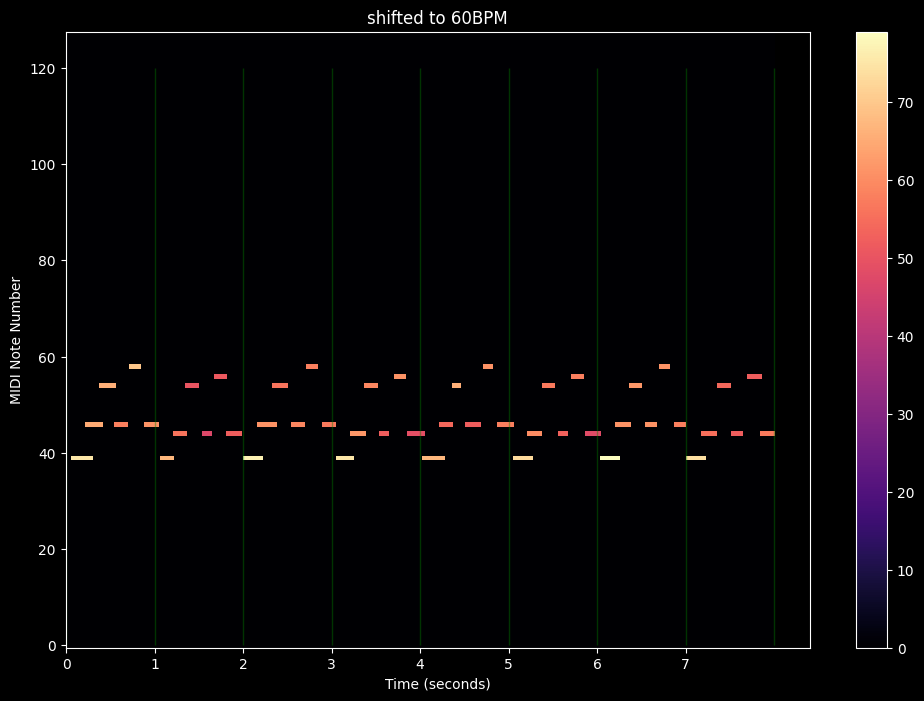

[15:32:16.603369] p2 beat 8 (0.99465s)[15:32:16.622478] beat 8    (1.00196s)	go!
[15:32:16.631437] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:16.631839] p1 beat 0 (0.00037s)

[15:32:17.613267] beat 1    (0.99078s)[15:32:17.613494] p2 waiting for file
[15:32:17.638422] p1 beat 1 (1.00658s)

[15:32:18.633697] p1 beat 2 (0.99527s)
[15:32:18.665273] beat 2    (1.05201s)
[15:32:19.642758] p1 beat 3 (1.00906s)[15:32:19.661641] beat 3    (0.99637s)

[15:32:20.642753] p1 beat 4 (1.00000s)[15:32:20.661641] beat 4    (1.00000s)

[15:32:21.642755] p1 beat 5 (1.00000s)
[15:32:21.661666] beat 5    (1.00003s)
[15:32:22.642756] p1 beat 6 (1.00000s)
[15:32:22.655506] beat 6    (0.99384s)
[15:32:23.642789] p1 beat 7 (1.00003s)
[15:32:23.657601] beat 7    (1.00210s)	ready?
[15:32:23.679264] putting next file in p2's queue: tmp/playlist/20240213-100-02_0008-0016.mid True
[15:32:23.679836] p2 playing '20240213-100-02_0008-0016.mid' (100BPM --> 60BPM)
[15:32:23.

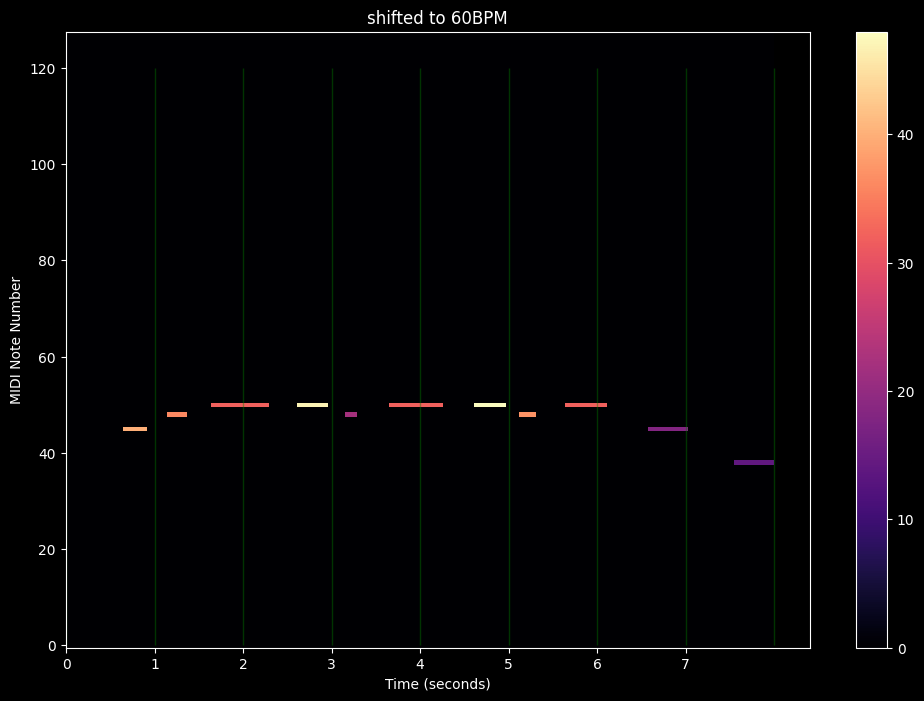

[15:32:24.631561] p1 beat 8 (0.98877s)
[15:32:24.650347] beat 8    (0.99275s)	go!
[15:32:24.665492] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:24.665757] p2 beat 0 (0.00025s)
[15:32:25.644186] beat 1    (0.99384s)[15:32:25.644413] p1 waiting for file

[15:32:25.693277] p2 beat 1 (1.02752s)
[15:32:26.676839] p2 beat 2 (0.98356s)[15:32:26.676953] beat 2    (1.03277s)

[15:32:27.669409] beat 3    (0.99245s)
[15:32:27.684043] p2 beat 3 (1.00721s)
[15:32:28.676808] beat 4    (1.00740s)[15:32:28.676884] p2 beat 4 (0.99284s)

[15:32:29.676809] p2 beat 5 (0.99992s)[15:32:29.676885] beat 5    (1.00008s)

[15:32:30.676541] beat 6    (0.99965s)[15:32:30.676617] p2 beat 6 (0.99981s)

[15:32:31.676797] p2 beat 7 (1.00018s)[15:32:31.683183] beat 7    (1.00664s)	ready?

[15:32:31.713633] putting next file in p1's queue: tmp/playlist/20240216-65-01_0216-0224.mid True
[15:32:31.714960] p1 playing '20240216-65-01_0216-0224.mid' (65BPM --> 60BPM)
[15:32:31.719

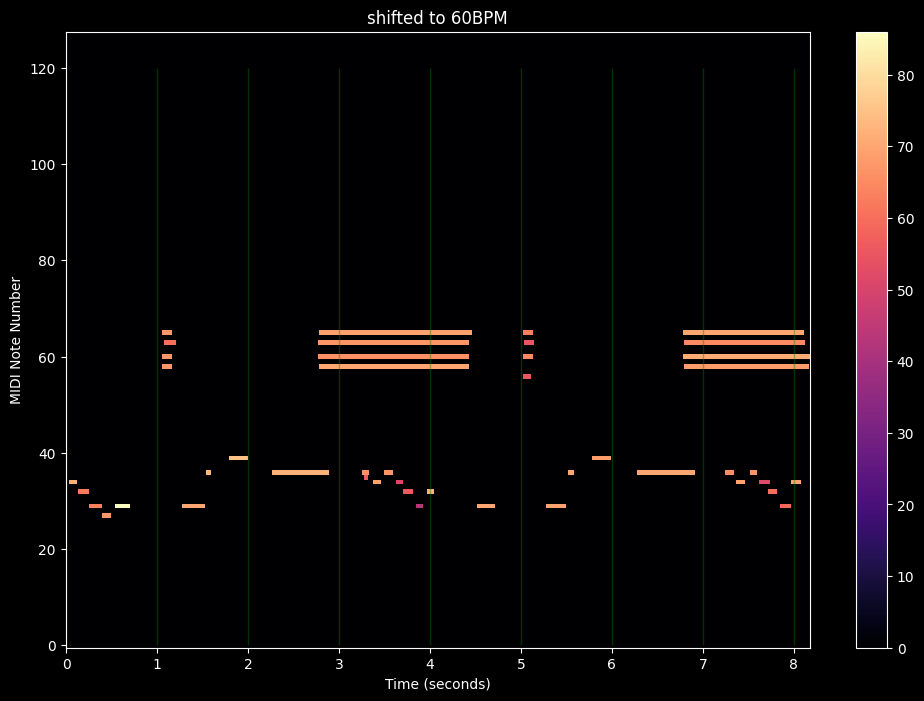

[15:32:32.678341] p2 beat 8 (1.00154s)
[15:32:32.684702] beat 8    (1.00152s)	go!
[15:32:32.712077] p1 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:32.712476] p1 beat 0 (0.00037s)
[15:32:33.681336] beat 1    (0.99663s)[15:32:33.681579] p2 waiting for file

[15:32:33.721853] p1 beat 1 (1.00938s)
[15:32:34.693526] beat 2    (1.01219s)
[15:32:34.723395] p1 beat 2 (1.00154s)
[15:32:35.692010] beat 3    (0.99848s)
[15:32:35.719061] p1 beat 3 (0.99566s)
[15:32:36.690385] beat 4    (0.99838s)
[15:32:36.734404] p1 beat 4 (1.01534s)
[15:32:37.696672] beat 5    (1.00629s)
[15:32:37.733810] p1 beat 5 (0.99940s)
[15:32:38.705228] beat 6    (1.00856s)
[15:32:38.725016] p1 beat 6 (0.99121s)
[15:32:39.708910] beat 7    (1.00368s)	ready?
[15:32:39.723687] p1 beat 7 (0.99867s)
[15:32:39.735859] putting next file in p2's queue: tmp/playlist/20231228-72-01_0232-0240.mid True
[15:32:39.736520] p2 playing '20231228-72-01_0232-0240.mid' (72BPM --> 60BPM)
[15:32:39.737

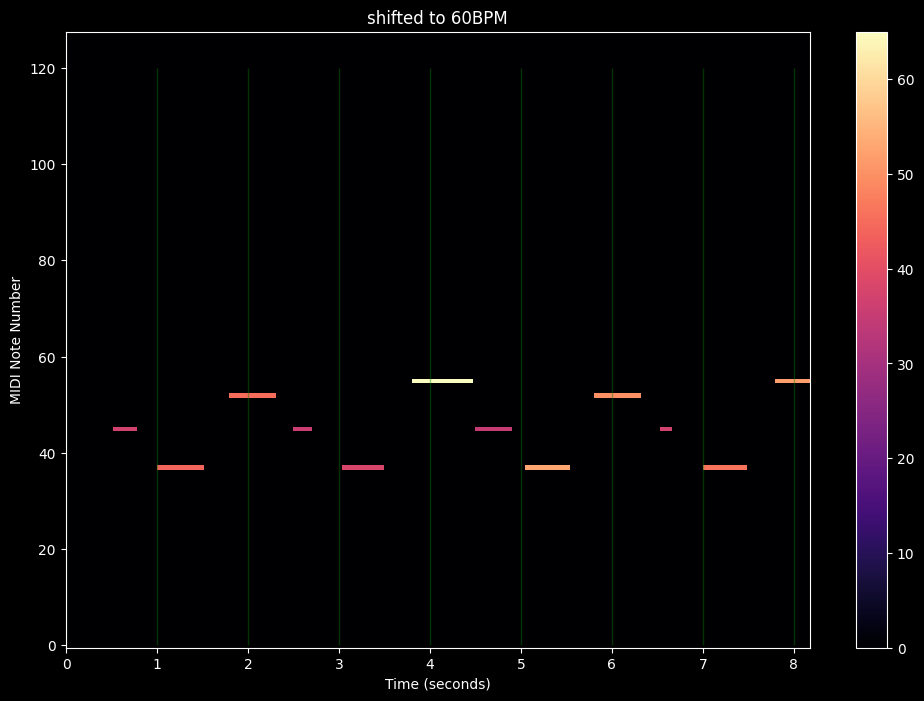

[15:32:39.973729] p1 shutting down
[15:32:40.701141] beat 8    (0.99223s)	go!
[15:32:40.710489] p2 playing
		playing at 60.0 BPM MetaMessage('set_tempo', tempo=1000000, time=0)
[15:32:40.711561] p2 shutting down
metronome shutting down


In [9]:
for file in os.listdir("tmp/playlist"):
    os.remove(os.path.join("tmp/playlist", file))

dataset_folder = "../data/datasets/careful"
all_segments = os.listdir(dataset_folder)
p1_main = True

# init threads
thread_p1.start()
thread_p2.start()
thread_metro.start()

# play
num_tracks = 0
while num_tracks < 20:
    if ready_event.is_set():
        # ready next file
        segment = all_segments[random.randint(0, len(all_segments))]
        seg_path = os.path.join(dataset_folder, segment)
        t_file = change_tempo(seg_path, bpm)

        # send to either p1 or p2
        if p1_main:
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] putting next file in p1's queue: {t_file}",
                give_p1.is_set(),
            )
            plst_p1.put(t_file)
            give_p1.clear()
        else:
            print(
                f"[{datetime.now().strftime('%H:%M:%S.%f')}] putting next file in p2's queue: {t_file}",
                give_p2.is_set(),
            )
            plst_p2.put(t_file)
            give_p2.clear()

        p1_main = not p1_main
        ready_event.clear()
        num_tracks += 1

        # plot
        # pm = pretty_midi.PrettyMIDI(seg_path)
        # tempo = int(segment.split("-")[1])
        # beats = calc_beats(tempo, 0.0, pm.get_end_time())
        # draw_piano_roll(
        #     pm.get_piano_roll(),
        #     beats=[b - beats[0] for b in beats],
        #     title=segment,
        # )
        pmt = pretty_midi.PrettyMIDI(t_file)
        beatst = calc_beats(bpm, 0.0, pmt.get_end_time())
        draw_piano_roll(
            pmt.get_piano_roll(),
            beats=[b - beatst[0] for b in beatst],
            title=f"shifted to {bpm}BPM",
        )

# kill threads
kill_p1.set()
thread_p1.join()
kill_p2.set()
thread_p2.join()
kill_metro.set()
thread_metro.join()